##  1-d Diffusion

A thin rod one meter in length is initially at 20 degrees the left end i clamped in intimate thermal contact with a heat sink fixed at zero degrees and the right end at 30 degrees.  What is the temperature of the rod as a function of position and time?  The diffusion constant is 0.0001.

$$\frac{ \partial T}{\partial t} = D \frac{\partial^2 T}{\partial x^2}$$

Subject to $T(x, t = 0) = 20$, $T(x==0, t) = 0$ and $T(x = 1, t) = 30$.


We will break our rod into discrete points uniformly spaced with a separation of $\Delta$.

|-----|-----|-----|-----|-----|-----| <br>
0 &nbsp;&nbsp;&nbsp; 1 &nbsp;&nbsp;&nbsp;2 &nbsp;&nbsp;&nbsp;3 &nbsp;&nbsp; ... &nbsp;&nbsp;  N-1 &nbsp;&nbsp;&nbsp;N

Discretize second derivative using a central difference formula:

$$\frac{\partial^2 T_I}{\partial x^2} \approx \frac{T_{i+1} - 2T_i + T_{i-1}}{(\Delta x)^2}$$

This transforms our PDE into:
\begin{array}{lll}
T_0              &    =      &  0 \\
\frac{dT_1}{dt}  &    =      & D \frac{T_2 - 2T_1 + T_0}{(\Delta x)^2} \\
\frac{dT_2}{dt}  &    =      & D \frac{T_3 - 2T_2 + T_1}{(\Delta x)^2} \\
\frac{dT_3}{dt}  &    =      & D \frac{T_4 - 2T_3 + T_2}{(\Delta x)^2} \\
                 &   \vdots  & \\
\frac{dT_N-1}{dt}  &    =      & D \frac{T_N - 2T_{N-1} + T_{N-2}}{(\Delta x)^2} \\
T_n                &    =      & 30
\end{array}

In [22]:
import numpy as np
from scipy import interpolate
from assimulo.solvers import IDA
from assimulo.problem import Implicit_Problem
import matplotlib.pyplot as plt
from assimulo.exception import TerminateSimulation
from time import time

from scipy.sparse import diags

%matplotlib inline

##  Generation Via Loop
We can generate the above system of equations for our solver using a for loop

In [23]:
class DiffusionLoop:
    D = 1e-4
    N = 101
    
    def __init__(self):
        tspan = 6000
        t0 = 0
        
        #  Initial conditions and boundary values
        T = 20 *np.ones( self.N )
        T[0] = 0 
        T[-1] = 30
        
        #  We need to provide a guess for Tprime for the solver.  We will use all zeros.
        Tprime = np.zeros( T.shape )
        
        #  Set the swtich variable.  The solver needs it but we are not using it.
        sw = T.size * [False]
        
        #  Tell the solver which variables are algebraic.
        algvar = T.size * [True]
        algvar[0] = False
        algvar[-1] = False
        
        #  Create the model object
        model = Implicit_Problem(self.equation_system, T, Tprime, t0, sw0 = sw)
        
        #  Create the simulation object and pass in the algvar variable.
        sim = IDA(model)
        sim.algvar = algvar
        
        #  Find consistant initial conditions
        sim.make_consistent('IDA_YA_YDP_INIT')
        
        #  Solve the system.
        self.t, self.T, self.Tprime = sim.simulate(tspan, 500)
    
    def equation_system(self, t, T, Tprime, sw):
        
        res = np.zeros( T.shape )
        Delta = 1.0 / (self.N - 1)
        
        res[0] = T[0] - 0
        for i in range(1, T.size - 1):
            res[i] = Tprime[i] - self.D / Delta**2 * (T[i+1] - 2 * T[i] + T[i-1])
        res[-1] = T[-1] - 30
        
        return res
        
        

In [24]:
#  Call the solver
start = time()
problem_loop = DiffusionLoop()
end = time()
print('Time = ', end - start)

Final Run Statistics: --- 

 Number of steps                                 : 241
 Number of function evaluations                  : 284
 Number of Jacobian evaluations                  : 31
 Number of function eval. due to Jacobian eval.  : 3131
 Number of error test failures                   : 5
 Number of nonlinear iterations                  : 284
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                       : IDA (BDF)
 Maximal order                : 5
 Suppressed algebr. variables : False
 Tolerances (absolute)        : 1e-06
 Tolerances (relative)        : 1e-06

Simulation interval    : 0.0 - 6000.0 seconds.
Elapsed simulation time: 0.795735200000081 seconds.
Time =  0.8644673824310303


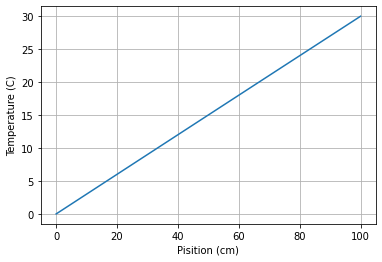

In [25]:
#  Plt steady state temperature distribution
x = np.linspace(0, 100, problem_loop.N)
plt.plot(x, problem_loop.T[-1, :])
plt.xlabel('Pisition (cm)')
plt.ylabel('Temperature (C)')
plt.grid(True)

##  Generation via Sparse Matrix

We can cast the system of equations in matrix form as follows:

$$
\left(
\begin{array}{l}
T_0 \\
\frac{dT_1}{dt} \\
\frac{dT_2}{dt} \\
\vdots \\
\frac{dT_{N-1}}{dt} \\
T_n
\end{array}
\right)
= \frac{D}{(\Delta x)^2}\left(
\begin{matrix}
1  &  0  & 0  & 0 & \cdots & 0 & 0 \\
1  & -2  & 1  & 0 & \cdots & 0 & 0 \\
0 & 1  & -2  & 1  & \cdots & 0 & 0  \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & 0 & 0 & 1 & -2 & 1 \\
0 & 0 & 0 & 0 & 0 & 0 & 1
\end{matrix}
\right) \left(
\begin{array}{l}
T_0 \\
T_1 \\
T_2 \\
\vdots \\
T_{N-1} \\
T_N
\end{array}
\right)
$$
​


We can then use this in our solver function to speed up the calculation.  The class below is the same as above except for the equation_system function.

In [26]:
class DiffusionMatrix:
    D = 1e-4
    N = 101
    
    def __init__(self):
        tspan = 6000
        t0 = 0
        
        T = 20 *np.ones( self.N )
        T[0] = 0 
        T[-1] = 30
        Tprime = np.zeros( T.shape )
        
        sw = T.size * [False]
        algvar = T.size * [True]
        algvar[0] = False
        algvar[-1] = False
        
        model = Implicit_Problem(self.equation_system, T, Tprime, t0, sw0 = sw)
        
        sim = IDA(model)
        sim.algvar = algvar
        sim.make_consistent('IDA_YA_YDP_INIT')
        
        self.t, self.T, self.Tprime = sim.simulate(tspan, 500)
    
    def equation_system(self, t, T, Tprime, sw):
        
        res = np.zeros( T.shape )
        Delta = 1.0 / (self.N - 1)
        
        #  Build our sparse matrix
        M = diags([1, -2, 1], [-1, 0, 1], shape = (T.size, T.size) )
        
        #  Generate all the differential equations via matrix multiplication
        res = Tprime - self.D / Delta**2 * M * T
        
        #  Set the boundary values
        res[0] = T[0] - 0
        res[-1] = T[-1] - 30
        
        return res
        
        

In [27]:
#  Call the solver
start = time()
problem_matrix = DiffusionMatrix()
end = time()
print('Time = ', end - start)

Final Run Statistics: --- 

 Number of steps                                 : 241
 Number of function evaluations                  : 284
 Number of Jacobian evaluations                  : 31
 Number of function eval. due to Jacobian eval.  : 3131
 Number of error test failures                   : 5
 Number of nonlinear iterations                  : 284
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                       : IDA (BDF)
 Maximal order                : 5
 Suppressed algebr. variables : False
 Tolerances (absolute)        : 1e-06
 Tolerances (relative)        : 1e-06

Simulation interval    : 0.0 - 6000.0 seconds.
Elapsed simulation time: 0.3746914000000743 seconds.
Time =  0.405914306640625


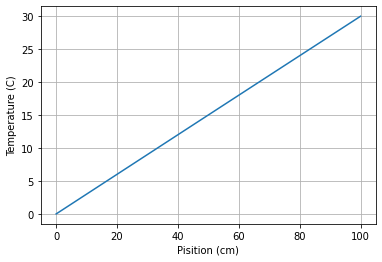

In [28]:
#  Plot steady state temperature distriubtion
x = np.linspace(0, 100, problem_matrix.N)
plt.plot(x, problem_matrix.T[-1, :])
plt.xlabel('Pisition (cm)')
plt.ylabel('Temperature (C)')
plt.grid(True)

Let's plot the temperature distribution at selected times.

t = 0.0s
t = 60.0s
t = 120.0s
t = 180.0s
t = 300.0s
t = 600.0s


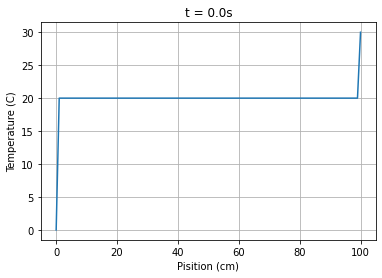

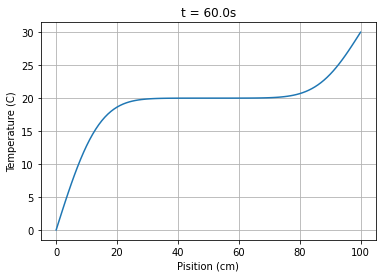

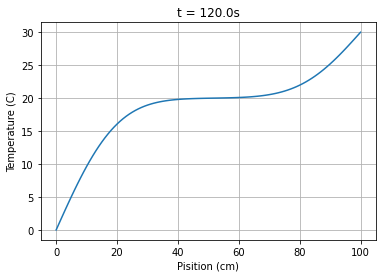

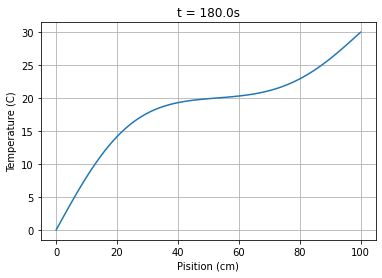

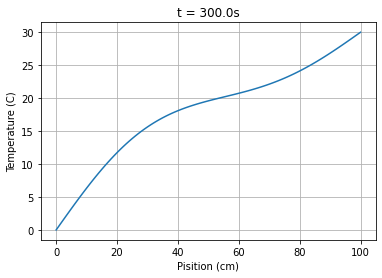

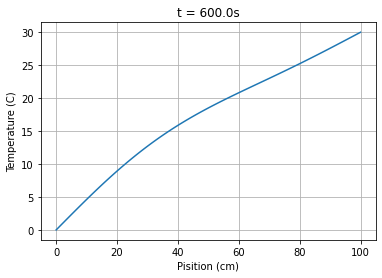

In [33]:
ind = [0, 5, 10, 15, 25, 50]
for i in ind:
    x = np.linspace(0, 100, problem_matrix.N)
    t = problem_matrix.t
    
    plt.figure()
    plt.plot(x, problem_loop.T[i, :])
    title = 't = '+ str(t[i]) + 's'
    plt.title(title)
    plt.xlabel('Pisition (cm)')
    plt.ylabel('Temperature (C)')
    plt.grid(True)